# Component Separation on CMB S4 and QUBIC+

In [2]:
import qubicplus
import CMBS4
import pysm3
import pysm3.units as u
from pysm3 import utils
import numpy as np
from qubic import camb_interface as qc
import healpy as hp
import matplotlib.pyplot as plt
import os
import random as rd
import string
import qubic
from importlib import reload
import pickle
import s4bi

center = qubic.equ2gal(0, -57)
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

nside=256
def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap_q = hp.ud_grade(hp.read_map('QUBIC-Typical-Coverage.fits'), 256)
covmap = get_coverage(0.03, nside)
skyconfig = {'cmb':42, 'dust':'d0'}

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

pkl_file = open('S4_dict.pkl', 'rb')
S4_dict = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('BI_dict.pkl', 'rb')
BI_dict = pickle.load(pkl_file)
pkl_file.close()

#from fgbuster import (separation_recipes, xForecast, CMB, Dust, Dust_2b, Synchrotron, FreeFree, PowerLaw,  # sky-fitting model
                      #basic_comp_sep)
import fgbuster as fgb
from fgbuster import basic_comp_sep, get_instrument


def separate(comp, instr, maps_to_separate, tol=1e-5, print_option=False):
    solver_options = {}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'Nelder-Mead', 'tol': tol, 'options': solver_options}
    try:
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res


def reconvolve(maps, fwhms, ref_fwhm, verbose=False):
    if verbose:
        print('Reconvolution to common FWHM')
    sig_conv = np.sqrt(ref_fwhm**2 - fwhms**2)
    maps_out = np.zeros_like(maps)
    for i in range(len(fwhms)):
        if sig_conv[i] == 0:
            if verbose:
                print('Map {0:} fwhmin={1:6.3f} fwhmout={2:6.3f} => We do not reconvolve'.format(i,
                                                                                             fwhms[i], ref_fwhm))
            maps_out[i,:] = maps[i,:]
        else:
            if verbose:
                print('Map {0:} fwhmin={1:6.3f} fwhmout={2:6.3f} => We reconvolve with {3:6.3f}'.format(i,
                                                                                                    fwhms[i],
                                                                                                    ref_fwhm,
                                                                                                    sig_conv[i]))
            maps_out[i,:] = hp.smoothing(maps[i,:], fwhm=np.deg2rad(sig_conv[i]), pol=True, verbose=False)
    return maps_out

# CMB-S4 case

In [2]:
reload(qubicplus)
reload(CMBS4)

ref_fwhm=1

# Computation of maps for CMB-S4 -> (9, 3, npix)

## We put maps at same resolution (0.5 degree) and with noise factor of 10

mapS4_noisy_withoutiib, mapS4_noiseless_withoutiib, noiseS4_withoutiib = CMBS4.S4(skyconfig, S4_dict).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.)

#mapS4_noisy_withiib, mapS4_noiseless_withiib, noiseS4_withiib = CMBS4.S4(skyconfig, S4_dict).getskymaps(
#                                                                    same_resol=ref_fwhm, 
#                                                                    iib=True, 
#                                                                    verbose=True, 
#                                                                    coverage=covmap, 
#                                                                    noise=True, 
#                                                                    signoise=10.)

/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/rcnnu297U8
  warnings.warn(f"Access data from {full_path}")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data fo

    FWHM : [1. 1. 1. 1. 1. 1. 1. 1. 1.] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg


# QUBIC+ case

In [3]:
mapqp_noisy_withoutiib, mapqp_noiseless_withoutiib, noiseqp_withoutiib = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.)

#mapqp_noisy_withiib, mapqp_noiseless_withiib, noiseqp_withiib = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
#                                                                    same_resol=ref_fwhm, 
#                                                                    iib=True, 
#                                                                    verbose=True, 
#                                                                    coverage=covmap, 
#                                                                    noise=True, 
#                                                                    signoise=10.)

/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/E67bxHQTMH
  warnings.warn(f"Access data from {full_path}")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data fo

    FWHM : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] deg 
    nus : [ 18.    19.    20.    21.    22.    26.4   28.2   30.    31.8   33.6
  35.2   37.6   40.    42.4   44.8   76.84  80.92  85.    89.08  93.16
  85.88  90.44  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76
 141.36 148.18 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36
 246.24 258.12 270.   281.88 293.76] GHz 
    Bandwidth : [ 1.    1.    1.    1.    1.    1.8   1.8   1.8   1.8   1.8   2.4   2.4
  2.4   2.4   2.4   4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvo

In [10]:
comp = [Dust(nu0=150.), CMB()]

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

# QUBIC+
instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*ref_fwhm*60


r_qp_withoutiib=separate(comp, instr, mapqp_noisy_withoutiib[:, :, pixok], tol=1e-6)

# CMB-S4
instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*ref_fwhm*60
r_s4_withoutiib=separate(comp, instr, mapS4_noisy_withoutiib[:, :, pixok], tol=1e-6)

print('Without iib : \n \n')
print('QUBIC+ -> beta_d = {:.6f} & T = {:.6f}'.format(r_qp_withoutiib.x[0], r_qp_withoutiib.x[1]))
print('CMB-S4 -> beta_d = {:.6f} & T = {:.6f}'.format(r_s4_withoutiib.x[0], r_s4_withoutiib.x[1]))

NameError: name 'ref_fwhm' is not defined

# MC

In [5]:
ref_fwhm=0.5

def give_me_truemaps(config, nu0, ref_fwhm, pixok):
    sky = qubicplus.QUBICplus(config, BI_dict).get_sky()
    maps = sky.get_emission(nu0*u.GHz, None)*utils.bandpass_unit_conversion(nu0*u.GHz,None, u.uK_CMB)
    maps = hp.sphtfunc.smoothing(maps, fwhm=np.deg2rad(ref_fwhm),verbose=False)
    maps[:, ~pixok] = hp.UNSEEN
    return maps
    
truecmb = give_me_truemaps({'cmb':42}, 150, ref_fwhm, pixok)
truedust = give_me_truemaps({'dust':'d0'}, 150, ref_fwhm, pixok)

/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/vlDyqHIShT
  warnings.warn(f"Access data from {full_path}")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data fo

In [6]:
import pickle

rx_s4=np.zeros((2, 2000))
rx_qp=np.zeros((2, 2000))


with open('results/betatemp_estimation_seed42_2000reals.pkl', 'rb') as f:
    data = pickle.load(f)
    rx_s4[0, :] = data['r_x_s4'][0]
    rx_s4[1, :] = data['r_x_s4'][1]
    rx_qp[0, :] = data['r_x_qp'][0]
    rx_qp[1, :] = data['r_x_qp'][1]

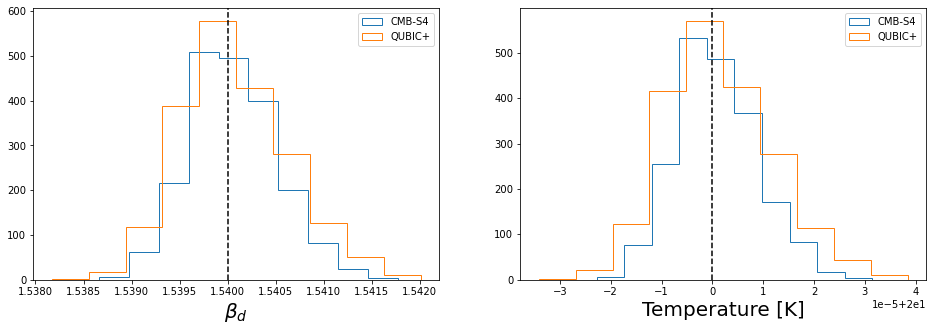

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(rx_s4[0], bins=10, label = 'CMB-S4', histtype='step')
plt.hist(rx_qp[0], bins=10, label='QUBIC+', histtype='step')


plt.axvline(1.54, ls='--', color='black')
plt.xlabel(r'$\beta_d$', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(rx_s4[1], bins=10, label = 'CMB-S4', histtype='step')
plt.hist(rx_qp[1], bins=10, label='QUBIC+', histtype='step')
plt.axvline(20, ls='--', color='black')
plt.legend()
plt.xlabel('Temperature [K]', fontsize=20)

plt.show()

# With iib

In [8]:
mapS4_noisy_withiib, mapS4_noiseless_withiib, noiseS4_withiib = CMBS4.S4(skyconfig, S4_dict).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=True, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.)

/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/gqDAdImloR
  warnings.warn(f"Access data from {full_path}")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/Users/mathiasregnier/miniconda3/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data fo

    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Integrated from 17.50 to 22.50 GHz
Reconvolution to 0.50 deg
Integrated from 25.50 to 34.50 GHz
Reconvolution to 0.50 deg
Integrated from 34.00 to 46.00 GHz
Reconvolution to 0.50 deg
Integrated from 74.80 to 95.20 GHz
Reconvolution to 0.50 deg
Integrated from 83.60 to 106.40 GHz
Reconvolution to 0.50 deg
Integrated from 129.05 to 160.95 GHz
Reconvolution to 0.50 deg
Integrated from 137.95 to 172.05 GHz
Reconvolution to 0.50 deg
Integrated from 195.80 to 244.20 GHz
Reconvolution to 0.50 deg
Integrated from 240.30 to 299.70 GHz
Reconvolution to 0.50 deg


In [73]:


a=[]
b=[]
c=[]
d=[]
k=0
n=4
for f in S4_dict['frequency']:
    print(k)
    freqs = np.linspace(S4_dict['edges'][k][0], S4_dict['edges'][k][1], n)
    w = np.ones(len(freqs))
    a.append(freqs)
    b.append(np.ones(n)*ref_fwhm*60)
    c.append(np.ones(n)*S4_dict['depth_i'][k])
    d.append(np.ones(n)*S4_dict['depth_p'][k])
    k+=1

0


NameError: name 'ref_fwhm' is not defined

In [112]:
a

[array([17.5       , 19.16666667, 20.83333333, 22.5       ]),
 array([25.5, 28.5, 31.5, 34.5]),
 array([34., 38., 42., 46.]),
 array([74.8, 81.6, 88.4, 95.2]),
 array([ 83.6,  91.2,  98.8, 106.4]),
 array([129.05      , 139.68333333, 150.31666667, 160.95      ]),
 array([137.95      , 149.31666667, 160.68333333, 172.05      ]),
 array([195.8       , 211.93333333, 228.06666667, 244.2       ]),
 array([240.3, 260.1, 279.9, 299.7])]

In [114]:
# CMB-S4
comp=[Dust(nu0=150), CMB()]
instr = get_instrument('CMBS4')
instr.frequency = a
instr.fwhm = b
instr.depth_i = c
instr.depth_p = d
r_s4_withiib=separate(comp, instr, mapS4_noisy_withiib[:, :, pixok], tol=1e-6)

ValueError: setting an array element with a sequence.

In [109]:
r_s4_withiib.x

array([ 1.9787874, 20.0070429])

In [110]:
instr

,frequency,depth_p,depth_i,fwhm,f_sky,type,experiment
0,"[17.5, 19.166666666666668, 20.833333333333332,...","[10.55, 10.55, 10.55, 10.55]","[16.5, 16.5, 16.5, 16.5]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
1,"[25.5, 28.5, 31.5, 34.5]","[6.025, 6.025, 6.025, 6.025]","[9.36, 9.36, 9.36, 9.36]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
2,"[34.0, 38.0, 42.0, 46.0]","[7.625, 7.625, 7.625, 7.625]","[11.85, 11.85, 11.85, 11.85]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
3,"[74.8, 81.6, 88.4, 95.2]","[1.3050000000000002, 1.3050000000000002, 1.305...","[2.02, 2.02, 2.02, 2.02]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
4,"[83.6, 91.2, 98.8, 106.4]","[1.15, 1.15, 1.15, 1.15]","[1.78, 1.78, 1.78, 1.78]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
5,"[129.05, 139.68333333333334, 150.3166666666667...","[1.78, 1.78, 1.78, 1.78]","[3.89, 3.89, 3.89, 3.89]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
6,"[137.95, 149.31666666666666, 160.6833333333333...","[1.91, 1.91, 1.91, 1.91]","[4.16, 4.16, 4.16, 4.16]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
7,"[195.8, 211.93333333333334, 228.0666666666667,...","[4.654999999999999, 4.654999999999999, 4.65499...","[10.15, 10.15, 10.15, 10.15]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4
8,"[240.3, 260.1, 279.90000000000003, 299.7000000...","[7.984999999999999, 7.984999999999999, 7.98499...","[17.4, 17.4, 17.4, 17.4]","[60.0, 60.0, 60.0, 60.0]",0.03,ground,CMBS4


In [9]:
import scipy

In [10]:
scipy.curve_fit

AttributeError: module 'scipy' has no attribute 'curve_fit'

In [14]:
scipy.optimize.curve_fit

<function scipy.optimize.minpack.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)>